In [7]:
%matplotlib inline
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']

%config InlineBackend.figure_format = notebook_screen_res
from utils import *

In [8]:
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

num_trials = tf.constant([0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])

# Prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data, tf.constant([[1, 0]]), 'CONSTANT')

# compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trial intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

probs_of_heads = tf.linspace(start=0., stop=1., num=100, name='linspace')
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))

In [11]:
[num_trials_,
probs_of_heads_,
observed_probs_heads_,
cumulative_headcounts_,
] = evaluate([
    num_trials,
    probs_of_heads,
    observed_probs_heads,
    cumulative_headcounts
])

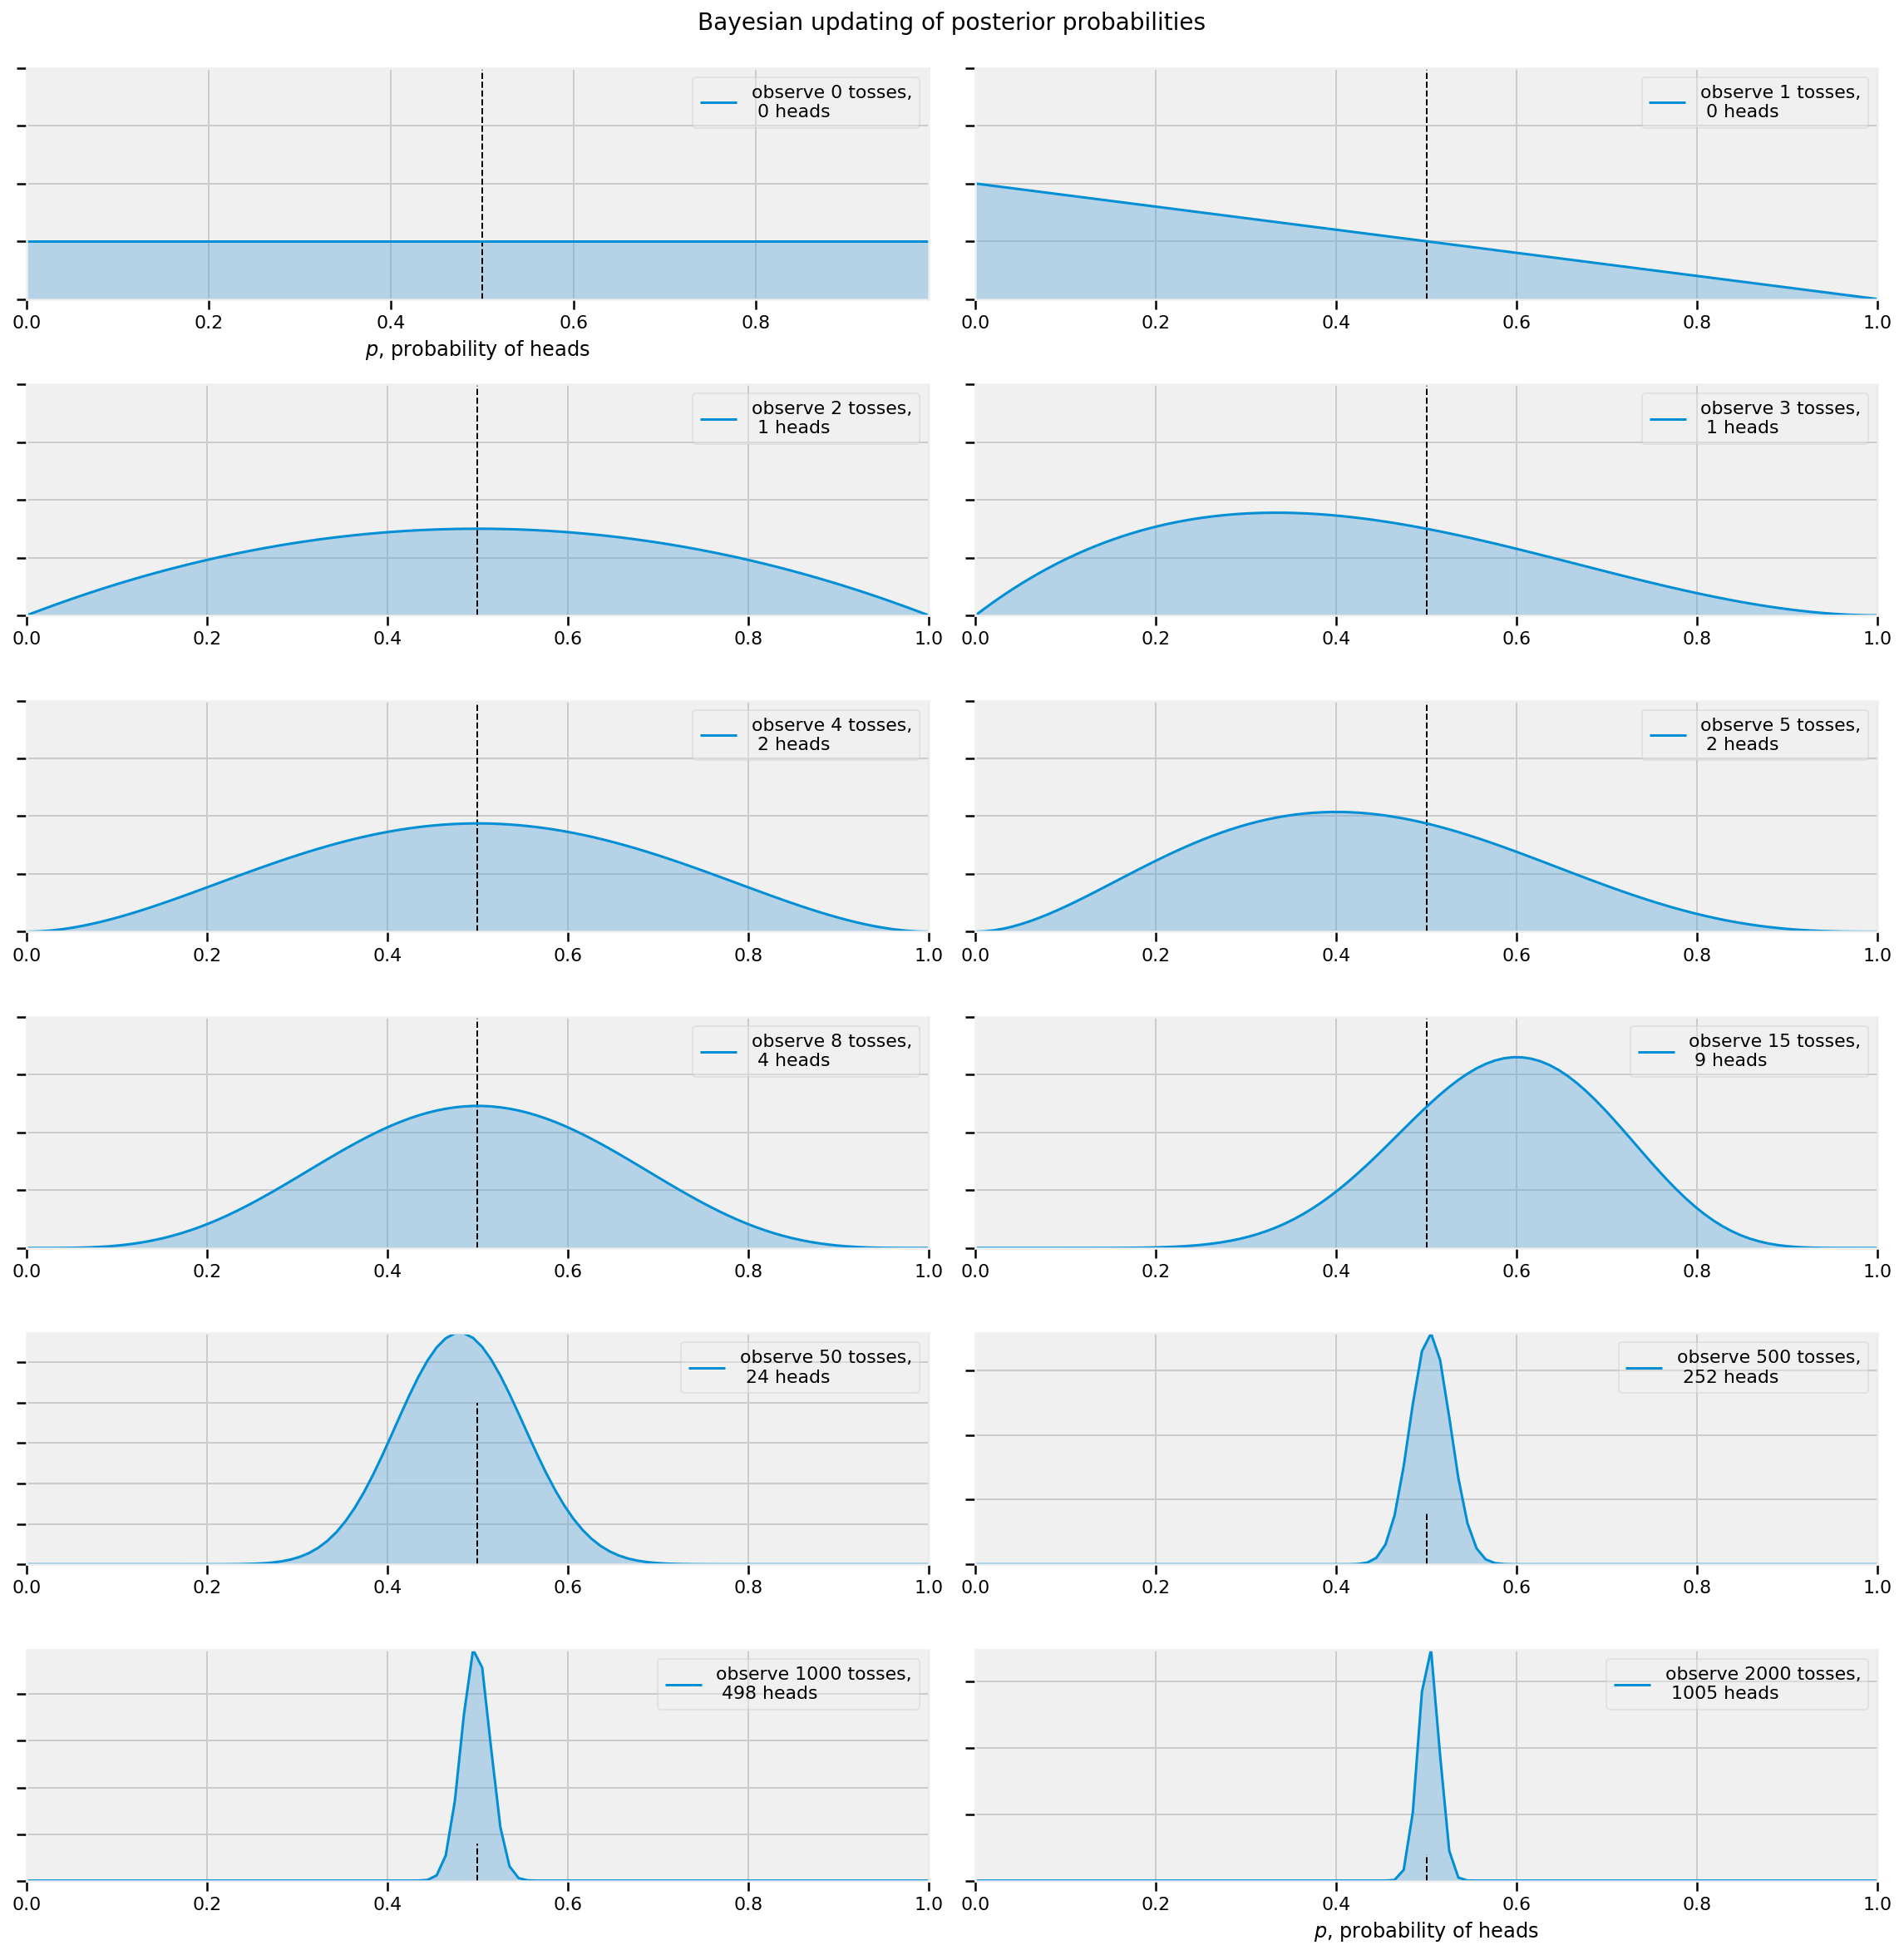

In [12]:
plt.figure(figsize(16, 16))
for i in range(len(num_trials_)):
    sx = plt.subplot(len(num_trials_)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(num_trials_)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads_, observed_probs_heads_[i], 
             label="observe %d tosses,\n %d heads" % (num_trials_[i], cumulative_headcounts_[i]))
    plt.fill_between(probs_of_heads_, 0, observed_probs_heads_[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

W0725 18:24:48.462033 140681783961408 deprecation.py:323] From /home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/venv/lib/python3.7/site-packages/tensorflow_probability/python/distributions/poisson.py:193: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<Figure size 900x576 with 0 Axes>

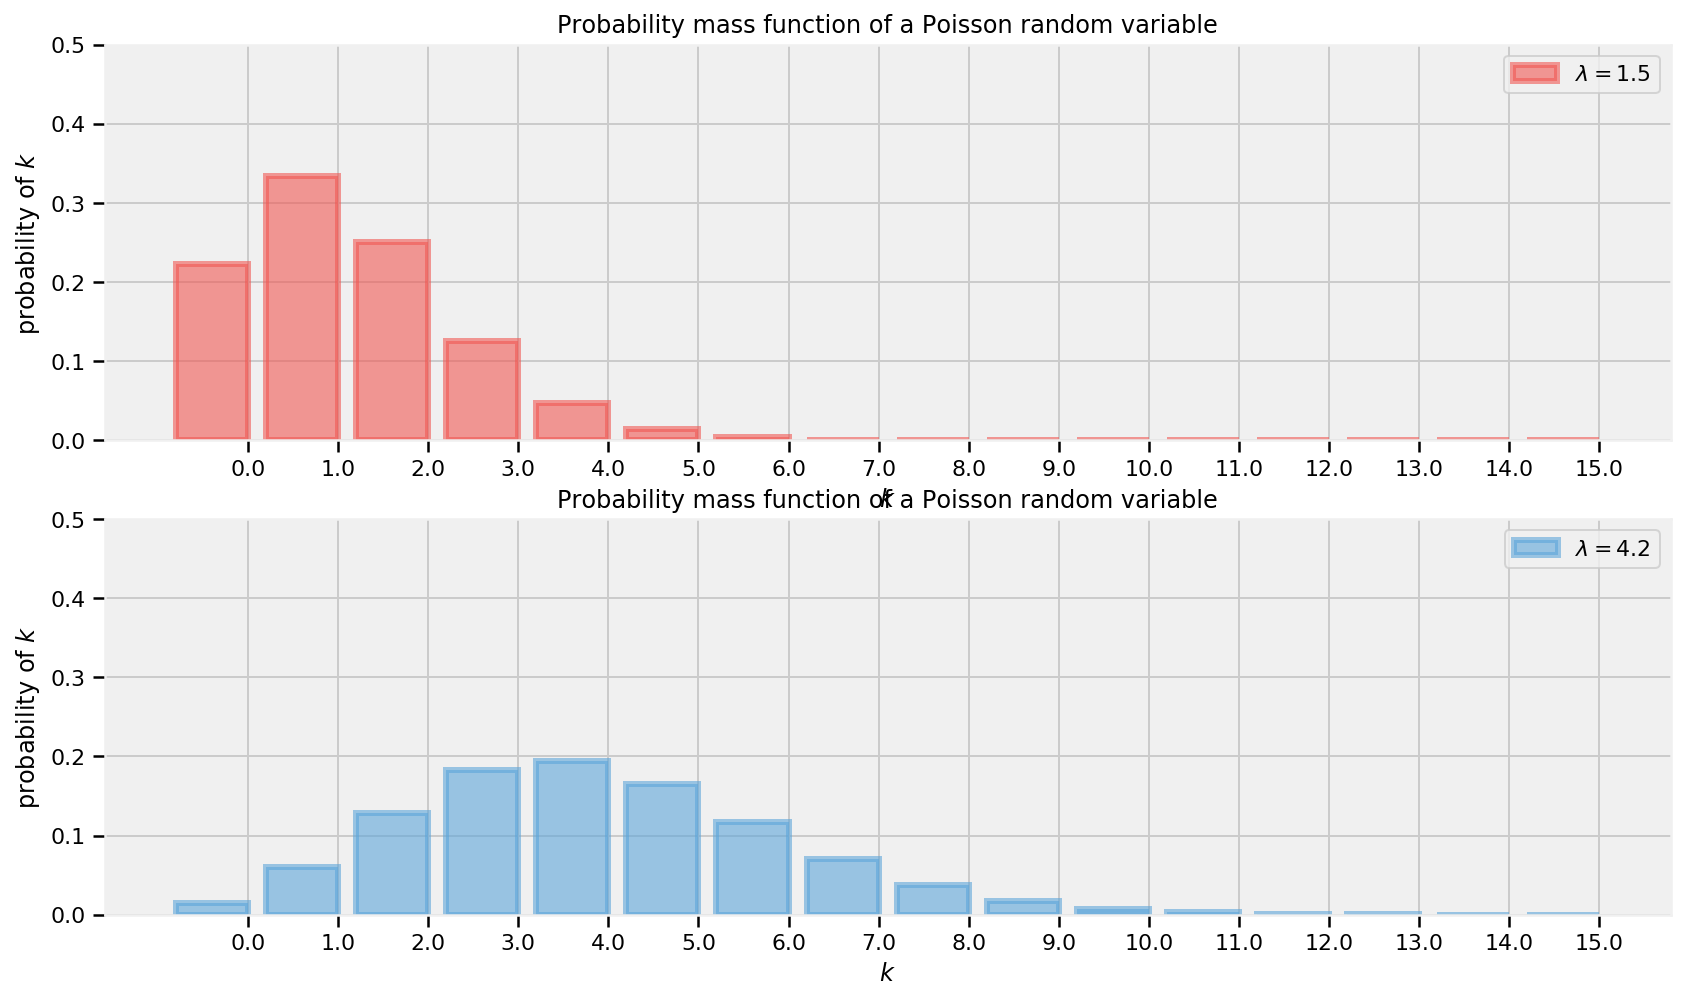

In [13]:
x = tf.range(start=0., limit=16.)
lambdas = tf.constant([1.5, 4.25])

poi_pmf = tfd.Poisson(
    rate=lambdas[:, tf.newaxis]).prob(x)

# Execute graph
[
    x_, 
    lambdas_,
    poi_pmf_,
] = evaluate([
    x,
    lambdas,
    poi_pmf,
])

plt.figure(figsize=(12.5, 8))

plt.figure(figsize=(12.5, 8))

# Display results in two different histograms, for easier comparison
colours = [TFColor[0], TFColor[3]]
for i in [0,1]:
    ax = plt.subplot(2,1,i+1)
    ax.set_autoscaley_on(False)
    plt.title("Probability mass function of a Poisson random variable");

    plt.bar(x_,
          poi_pmf_[i],
          color=colours[i],
          label=r"$\lambda = %.1f$" % lambdas_[i], alpha=0.60,
          edgecolor=colours[i], lw="3")
    plt.xticks(x_ + 0.4, x_)
    plt.ylim([0, .5])
    plt.legend()
    plt.ylabel(r"probability of $k$")
    plt.xlabel(r"$k$")

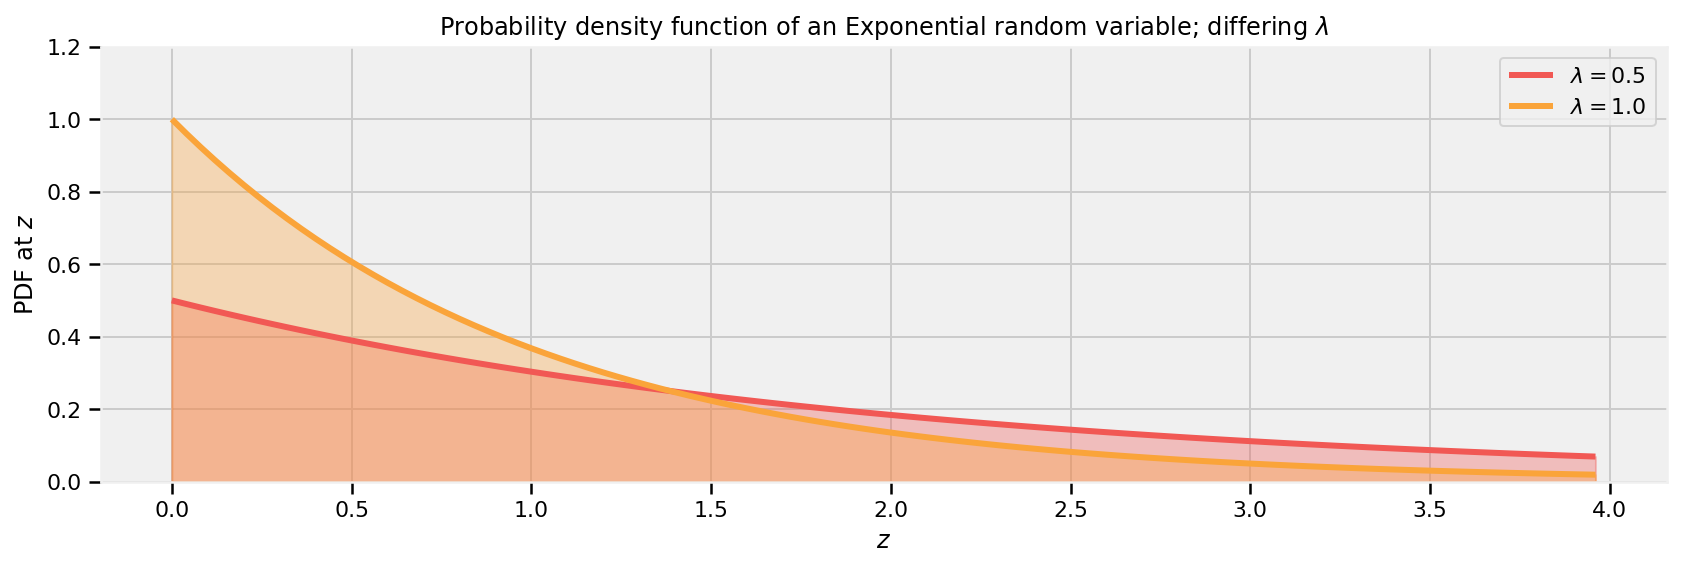

In [14]:
# Defining our data and assumptions (use tf.linspace for continuous)
a = tf.range(start=0, limit=4, delta=0.04)
a = a[..., tf.newaxis]
lambdas = tf.constant([0.5, 1.0])

# Now we use TFP to compute probabilities in a vectorized manner.
expo_pdf = tfd.Exponential(rate=lambdas).prob(a)

# convert from TF to numpy
[
    a_,
    lambdas_,
    expo_pdf_,
] = evaluate([
    a,
    lambdas,
    expo_pdf,
])

# Visualizing our results
plt.figure(figsize=(12.5, 4))
for i in range(lambdas_.size):
    plt.plot(a_.T[0], expo_pdf_.T[[i]][0],
             lw=3, color=TFColor[i], label=r"$\lambda = %.1f$" % lambdas_[i])
    plt.fill_between(a_.T[0], expo_pdf_.T[[i]][0],
                         color=TFColor[i], alpha=.33)
plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title(r"Probability density function of an Exponential random variable; differing $\lambda$");

In [15]:
import pandas as pd

In [18]:
count_data_ = pd.read_csv('../Chapter1_Introduction/data/txtdata.csv', header=None)[0].values
count_data = tf.constant(list(count_data_), dtype=tf.float32)

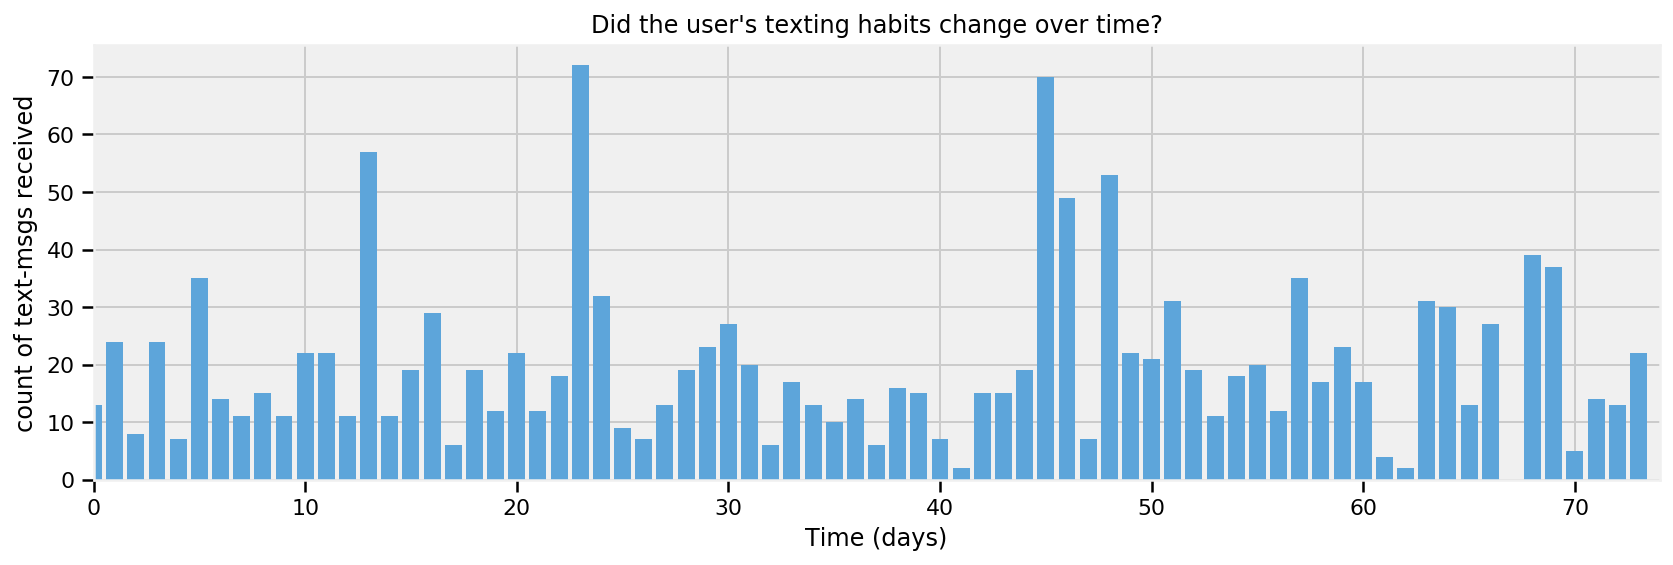

In [19]:
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0])

[
    count_data_, 
    n_count_data_, 
    days_,
] = evaluate([
    count_data, 
    n_count_data,
    days,
])

# Visualizing the Results
    
plt.figure(figsize=(12.5, 4))
plt.bar(days_, count_data_, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data_[0]);

In [20]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
    
    alpha = np.array(1. / count_data.mean(), np.float32)
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    
    rv_tau = tfd.Uniform()
    
    lambda_ = tf.gather(
        [lambda_1, lambda_2],
        indices=tf.to_int32(tau * count_data.size <= np.arange(count_data.size)))
    rv_observation = tfd.Poisson(rate=lambda_)
    
    return (
        rv_lambda_1.log_prob(lambda_1)
        + rv_lambda_2.log_prob(lambda_2)
        + rv_tau.log_prob(tau)
        + tf.reduce_sum(rv_observation.log_prob(count_data)))

In [31]:
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(), # Maps a positive real to R.
    tfp.bijectors.Exp(), # Maps a positive real to R.
    tfp.bijectors.Sigmoid(), # Maps [0, 1] to R.
] 

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 

    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.to_int32(tau * tf.cast(tf.size(count_data), tf.float32) <= tf.cast(tf.range(tf.size(count_data)), tf.float32)))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

In [24]:
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

In [25]:
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

In [32]:
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=100000,
    num_burnin_steps=10000,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(None),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))

W0725 18:52:19.918318 140681783961408 deprecation.py:323] From <ipython-input-31-266d48d5848c>:28: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [36]:
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data), tf.float32))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(n_count_data)


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [37]:
evaluate(init_g)
evaluate(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_,
    expected_texts_per_day_,
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N,
    expected_texts_per_day,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.5878
final step size: 0.028601311147212982


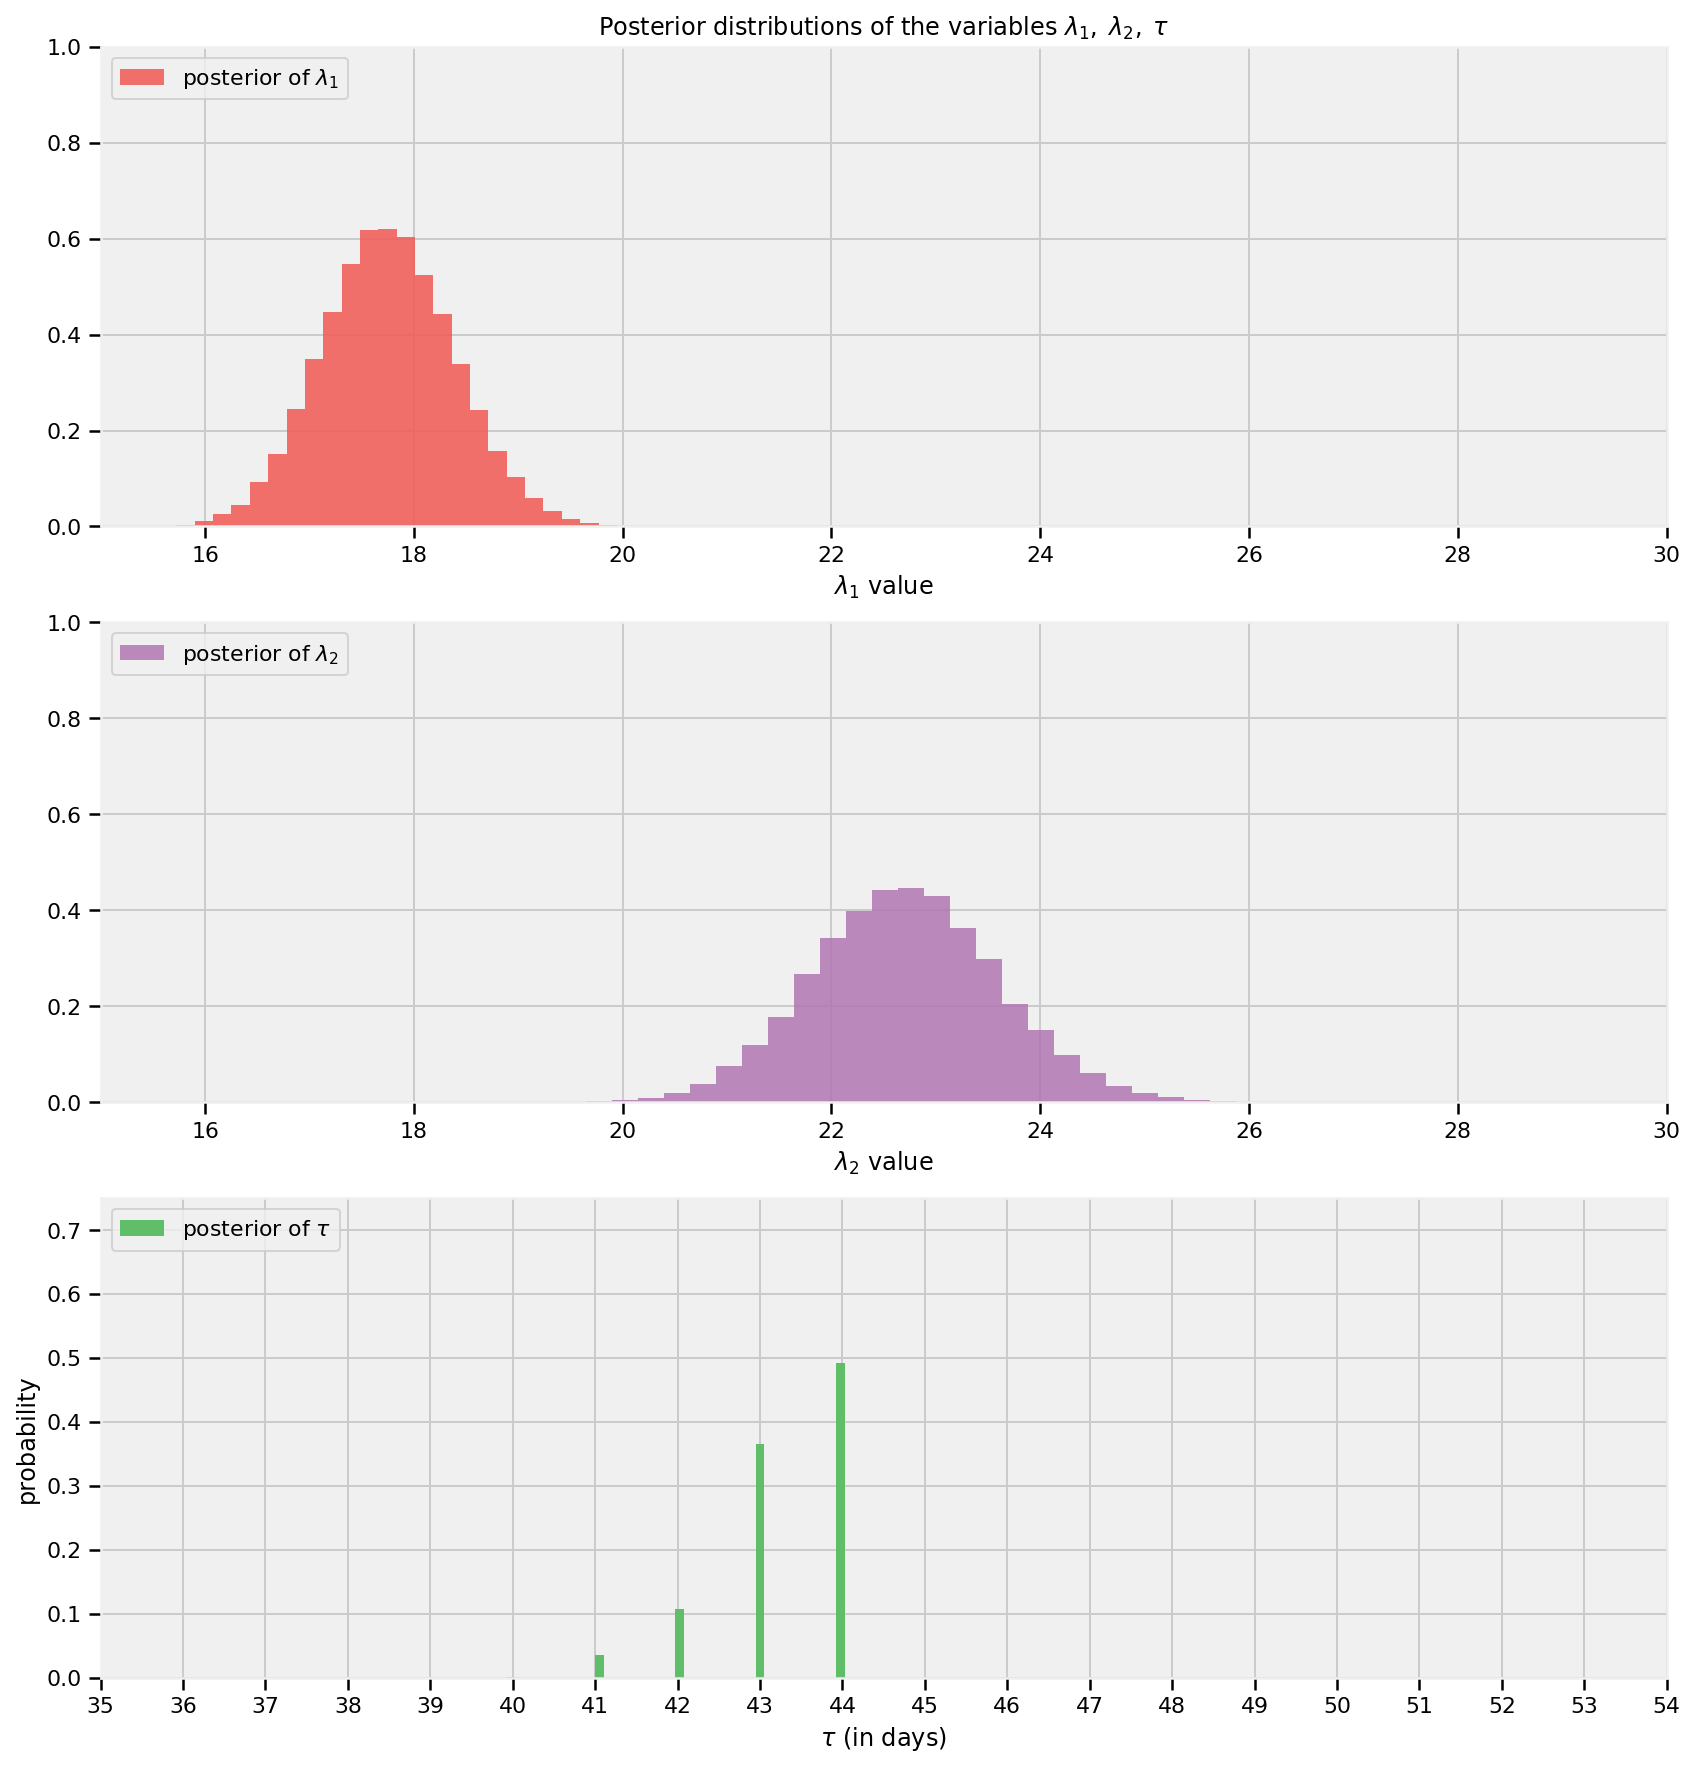

In [38]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=n_count_data_[0], alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data_[0]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data_)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

In [42]:
evaluate(tf.reduce_mean(lambda_1_samples + lambda_2_samples))

40.460304